In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jaxdem as jd
from bump_utils import get_closest_vertex_radius_for_mu_eff, find_num_vertices_for_target_mu_eff
from jaxdem.utils.geometricAsperityCreation import generate_asperities_2d

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
def draw(pos, rad, ax=None, scale=1.0):
    if ax is None:
        ax = plt.gca()
        ax.set_aspect('equal')
        extent = (max(np.linalg.norm(pos, axis=-1)) + max(rad)) * scale
        ax.set_xlim(-extent, +extent)
        ax.set_ylim(-extent, +extent)
    for p, r in zip(pos, rad):
        plt.gca().add_artist(Circle(p, r))
    return ax

W0127 08:49:37.984673 1528168 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0127 08:49:37.986561 1527988 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [ ]:
# probably need it in terms of some mass distribution
# then, when shapes change, as long as mass distribution is constant, it is sure to be valid

In [3]:
def cpoints(rad, nv):
    theta = 2 * np.pi * np.arange(nv) / nv
    return rad * np.column_stack((np.cos(theta), np.sin(theta)))

In [53]:
outer_radius = 0.5
outer_nv = 10

pos_outer = cpoints(outer_radius, outer_nv)
I_outer = np.sum(np.linalg.norm(pos_outer, axis=-1) ** 2)

c = 0.01
assert c < 1 / 4
inner_radius = outer_radius * c
inner_nv = int(np.floor(- outer_nv / (2 * (c ** 2 - 0.5))))
pos_inner = cpoints(inner_radius, inner_nv)
I_inner = np.sum(np.linalg.norm(pos_inner, axis=-1) ** 2)
I_composite = I_outer + I_inner

I_target = 0.5 * outer_radius ** 2 * (outer_nv + inner_nv)

abs(I_target - I_composite) / I_target



np.float64(9.999999999994457e-05)

In [54]:
def build_c_ring(outer_nv, outer_radius, n_rings):
    pos = []  # store the point positions here
    spacing = 2 * np.pi * outer_radius / outer_nv  # calculate uniform spacing for all rings
    for radius in outer_radius * np.arange(n_rings + 1)[1::] / n_rings:
        nv = int(np.floor(2 * np.pi * radius / spacing))  # calculate number of points given spacing
        if nv <= 1:  # have to have at least 2 points to form a valid ring
            break
        theta = 2 * np.pi * np.arange(nv) / nv  # uniform spacing of points
        pos.append(radius * np.column_stack((np.cos(theta), np.sin(theta))))  # point positions on ring
    if len(pos) == 0:
        return None
    return np.concatenate(pos)

def build_c_ring_gpt(outer_nv, outer_radius, n_rings):
    pos = []
    spacing = 2 * np.pi * outer_radius / outer_nv
    dr = outer_radius / n_rings
    radii = (np.arange(n_rings) + 0.5) * dr
    for r in radii:
        nv_ring = max(1, int(np.round(2 * np.pi * r / spacing)))  # allow nv=1 near center  GPTs version
        # nv_ring = int(np.round(2 * np.pi * r / spacing))
        # if nv_ring <= 1:
        #     break
        theta = 2 * np.pi * np.arange(nv_ring) / nv_ring
        pos.append(r * np.column_stack((np.cos(theta), np.sin(theta))))
    if len(pos) == 0:
        return None
    return np.concatenate(pos)

0.0497993383335816

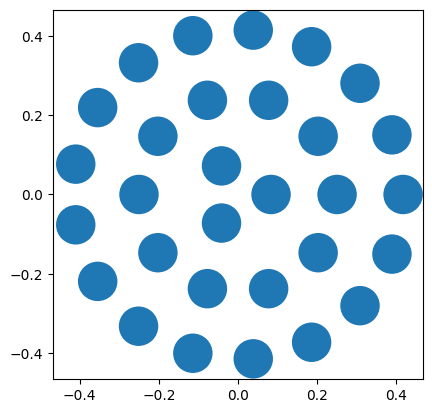

In [110]:
mu = 1
outer_radius = 0.5
outer_nv = 20
asperity_radius = get_closest_vertex_radius_for_mu_eff(mu, outer_radius, outer_nv)
n_rings = int(np.floor(outer_radius / (2 * np.pi * outer_radius / outer_nv)))

pos = build_c_ring_gpt(outer_nv, outer_radius, n_rings)
rad = np.ones(pos.shape[0]) * asperity_radius

draw(pos, rad)

I_composite = np.sum(np.linalg.norm(pos, axis=-1) ** 2)
I_target = 0.5 * outer_radius ** 2 * pos.shape[0]
abs(I_composite - I_target) / I_target, pos.shape[0]

asperity_radius

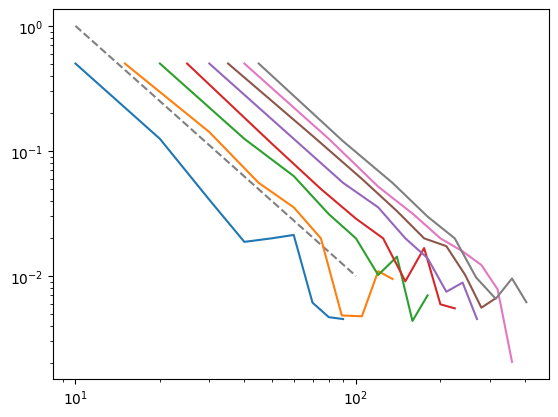

In [62]:
# inputs: number of points in outer ring, outer ring size, number of rings
outer_radius = 0.5
outer_nv_mesh = np.arange(2, 10) * 10
n_rings_mesh = np.arange(1, 10)

I_disk = 0.5 * outer_radius ** 2

for outer_nv in outer_nv_mesh:
    I_err = []
    nv = []
    for n_rings in n_rings_mesh:
        pos = build_c_ring_gpt(outer_nv, outer_radius, n_rings)
        if pos is None:
            I_err.append(np.nan)
            nv.append(np.nan)
            continue
        I = np.mean(np.linalg.norm(pos, axis=-1) ** 2)
        I_err.append(abs(I - I_disk) / I_disk)
        nv.append(pos.shape[0])
    plt.plot(nv, I_err, )
plt.yscale('log')
plt.xscale('log')

x = np.logspace(1, 2)
plt.plot(x, 100 / x ** 2, c='k', ls='--', alpha=0.5, zorder=0)

In [ ]:
dim = 2
mu_eff = 1.0
nv = 40
particle_radius = 0.5

asperity_radius = get_closest_vertex_radius_for_mu_eff(mu_eff, particle_radius, nv)


In [23]:
# inputs: number of points in outer ring, outer ring size, number of rings
outer_nv = 30
outer_radius = 0.5
n_rings = 2

pos = []  # store the point positions here
spacing = 2 * np.pi * outer_radius / outer_nv  # calculate uniform spacing for all rings
for radius in outer_radius * np.arange(n_rings + 1)[1::] / n_rings:
    nv = int(np.floor(2 * np.pi * radius / spacing))  # calculate number of points given spacing
    if nv <= 1:  # have to have at least 2 points to form a valid ring
        break
    theta = 2 * np.pi * np.arange(nv) / nv  # uniform spacing of points
    pos.append(radius * np.column_stack((np.cos(theta), np.sin(theta))))  # point positions on ring

pos = np.concatenate(pos)

# keeping the total mass fixed, we need the massless part of the inertias to match
# i.e.: 1/2 r^2 (disk) == sum(r_i^2) (points)
I_points = np.mean(np.linalg.norm(pos, axis=-1) ** 2)
I_disk = 0.5 * outer_radius ** 2

abs(I_points - I_disk) / I_disk, pos.size

(np.float64(0.5), 90)

(np.float64(0.05555555555555591), 45)

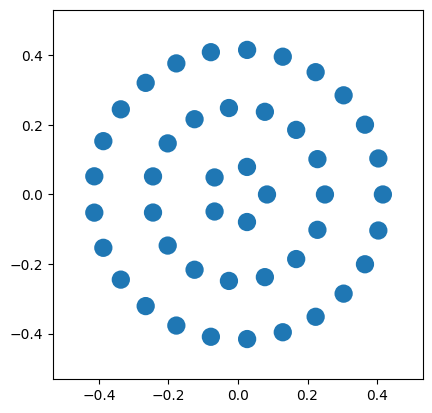

In [ ]:
# inputs
outer_nv = 30
outer_radius = 0.5
n_rings = 3

pos = []
spacing = 2 * np.pi * outer_radius / outer_nv
dr = outer_radius / n_rings

# midpoint radii represent annuli [r-dr/2, r+dr/2]
radii = (np.arange(n_rings) + 0.5) * dr

for r in radii:
    # nv_ring = max(1, int(np.round(2 * np.pi * r / spacing)))  # allow nv=1 near center
    nv_ring = int(np.round(2 * np.pi * r / spacing))
    if nv_ring <= 1:
        break
    theta = 2 * np.pi * np.arange(nv_ring) / nv_ring
    pos.append(r * np.column_stack((np.cos(theta), np.sin(theta))))

pos = np.concatenate(pos)

I_points = np.mean(np.sum(pos**2, axis=-1))          # mean(r^2)
I_disk = 0.5 * outer_radius**2                     # R^2/2
rel_err = abs(I_points - I_disk) / I_disk

rad = np.ones(pos.shape[0]) * asperity_radius
ax = draw(pos, rad, scale=1.2)

rel_err, pos.shape[0]

(np.float64(1.3539815414231477), 0.7853981633974483)

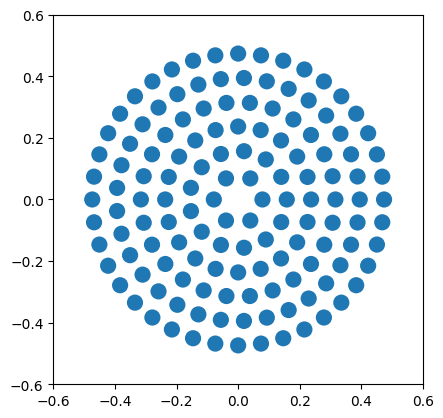

In [87]:
# calculate the moment of inertia for a finite set of point masses
# n > 1 vertices per ring
# constant mass density in all rings
# constant spacing in all rings
outer_core_radius = particle_radius - asperity_radius
spacing = 2 * np.pi * outer_core_radius / nv
density = 1
n_rings = 6
mass_vertex = spacing * density
core_radii = outer_core_radius * np.arange(n_rings + 1)[1:] / n_rings

pos = []
rad = []
for core_radius in core_radii:
    nv_ring = int(np.floor(2 * np.pi * core_radius / spacing))
    if nv_ring <= 1:
        break
    ring_mass = nv_ring * mass_vertex

    _pos, _rad = generate_asperities_2d(
        asperity_radius,
        core_radius + asperity_radius,
        nv_ring,
        core_type=None
    )
    pos.append(_pos)
    rad.append(_rad)
pos = np.concatenate(pos)
rad = np.concatenate(rad)

ax = draw(pos, rad, scale=1.2)

np.sum(mass_vertex * np.linalg.norm(pos, axis=-1) ** 2), 0.5 * density * 2 * np.pi * particle_radius ** 2

In [73]:
particle_radius, core_radius

(0.5, np.float64(0.4502006616664184))

<Axes: >

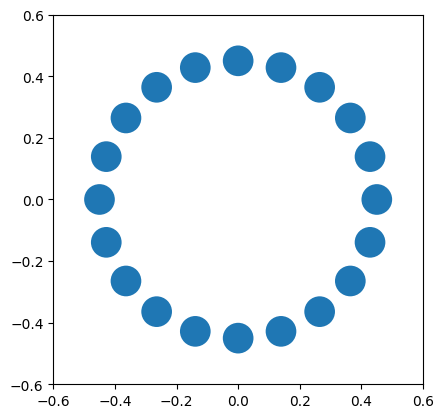

In [ ]:
pos, rad = generate_asperities_2d(
    asperity_radius,
    particle_radius,
    nv,
    core_type=None
)
ax = draw(pos, rad, scale=1.2)

pos, rad = generate_asperities_2d(
    asperity_radius,
    particle_radius,
    nv,
    core_type=None
)

draw(pos, rad, scale=1.2, ax=ax)